# Flight Delay Absorption Classification--Grid Search Model

## Step 1: Data loading and merging

* Task: Analyze the provided flight and weather data from "flights.csv" and "weather.csv" by merging them based on date, airport code, and time specifications. Then download the merged data as a CSV file for classification model building.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

FLIGHT_PATH = "/content/aa_flights_entire.csv" # Change according to actual directories
WEATHER_PATH = "/content/All_Hubs_Weather_EDA.csv"
flight_df = pd.read_csv(FLIGHT_PATH)
weather_df = pd.read_csv(WEATHER_PATH)

print("Flight DataFrame head:")
display(flight_df.head())

print("\nWeather DataFrame head:")
display(weather_df.head())

Flight DataFrame head:


,FL_DATE,MKT_UNIQUE_CARRIER,OP_CARRIER_FL_NUM,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,WHEELS_OFF,CRS_ARR_TIME,ARR_TIME,...,ORIGIN_UTC_OFFSET,DEST_UTC_OFFSET,CRS_DEP_TIME_UTC_MIN,DEP_TIME_UTC_MIN,CRS_ARR_TIME_UTC_MIN,ARR_TIME_UTC_MIN,CRS_DEP_TIME_UTC_HHMM,DEP_TIME_UTC_HHMM,CRS_ARR_TIME_UTC_HHMM,ARR_TIME_UTC_HHMM
0,2023-01-01,AA,1,JFK,LAX,730,726.0,743.0,1052,1054.0,...,-5,-8,750,746.0,1132,1134.0,1230,1226,1852,1854
1,2023-01-02,AA,1,JFK,LAX,730,723.0,742.0,1052,1037.0,...,-5,-8,750,743.0,1132,1117.0,1230,1223,1852,1837
2,2023-01-03,AA,1,JFK,LAX,730,807.0,829.0,1052,1140.0,...,-5,-8,750,787.0,1132,1180.0,1230,1307,1852,1940
3,2023-01-04,AA,1,JFK,LAX,730,727.0,747.0,1052,1039.0,...,-5,-8,750,747.0,1132,1119.0,1230,1227,1852,1839
4,2023-01-05,AA,1,JFK,LAX,730,725.0,746.0,1052,1046.0,...,-5,-8,750,745.0,1132,1126.0,1230,1225,1852,1846



Weather DataFrame head:


,station,time,temp_C,dewpoint_C,wind_dir_deg,wind_speed_kt,visibility_mi,pressure_mb,weather,Sky
0,KDFW,2023-01-01 00:00:00,18.0,7.0,180.0,8.0,10.0,1008.130685,NaN,"[('CLR', None, None)]"
1,KDFW,2023-01-01 00:00:00,18.3,6.7,180.0,7.0,NaN,NaN,NaN,NaN
2,KDFW,2023-01-01 00:05:00,18.0,7.0,180.0,8.0,10.0,1007.792045,NaN,"[('CLR', None, None)]"
3,KDFW,2023-01-01 00:10:00,19.0,7.0,180.0,8.0,10.0,1008.130685,NaN,"[('CLR', None, None)]"
4,KDFW,2023-01-01 00:15:00,19.0,7.0,180.0,7.0,10.0,1008.130685,NaN,"[('CLR', None, None)]"


In [ ]:
flight_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 399618 entries, 0 to 399617
Data columns (total 35 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   FL_DATE                399618 non-null  object 
 1   MKT_UNIQUE_CARRIER     399618 non-null  object 
 2   OP_CARRIER_FL_NUM      399618 non-null  int64  
 3   ORIGIN                 399618 non-null  object 
 4   DEST                   399618 non-null  object 
 5   CRS_DEP_TIME           399618 non-null  int64  
 6   DEP_TIME               399618 non-null  float64
 7   WHEELS_OFF             399618 non-null  float64
 8   CRS_ARR_TIME           399618 non-null  int64  
 9   ARR_TIME               399618 non-null  float64
 10  WHEELS_ON              399618 non-null  float64
 11  CANCELLED              399618 non-null  float64
 12  DIVERTED               399618 non-null  float64
 13  YEAR                   399618 non-null  int64  
 14  MONTH                  399618 non-nu

In [ ]:
weather_df.value_counts('weather')

,count
weather,
"[('-', None, 'RA', None, None)]",63668
"[('', None, '', 'BR', None)]",52607
"[('-', None, 'RA', None, None), ('', None, '', 'BR', None)]",32797
"[('', None, '', 'HZ', None)]",15524
"[('', None, 'RA', None, None), ('', None, '', 'BR', None)]",12798
...,...
"[('-', None, 'SNDZ', None, None)]",1
"[('VC', 'TS', '', None, None), ('+', None, 'RA', None, None), ('', None, '', 'FG', None)]",1
"[('VC', 'TS', '', None, None), ('', None, 'PL', None, None), ('', None, '', 'BR', None)]",1


In [ ]:
len(flight_df)

399618

In [ ]:
# Convert 'FL_DATE' in flight_df to datetime objects
flight_df['FL_DATE'] = pd.to_datetime(flight_df['FL_DATE'])

# Convert 'time' in weather_df to datetime objects
weather_df['time'] = pd.to_datetime(weather_df['time'])

# Create combined datetime columns for merging in flight_df
def combine_date_time(row, date_col, time_col):
    if pd.isna(row[date_col]) or pd.isna(row[time_col]):
        return pd.NaT
    # Ensure the time column is treated as a string in HH:MM format
    # Assuming the original time columns (DEP_TIME, ARR_TIME) are in a format like HMM or HHMM
    # Convert to string, pad with leading zeros if necessary, and format
    time_str = str(int(row[time_col])).zfill(4)
    hour = time_str[:2]
    minute = time_str[2:]
    # Combine date and time strings and convert to datetime
    try:
        return pd.to_datetime(f"{row[date_col].date()} {hour}:{minute}")
    except ValueError:
        return pd.NaT


flight_df['DEP_DATETIME'] = flight_df.apply(lambda row: combine_date_time(row, 'FL_DATE', 'DEP_TIME'), axis=1)
flight_df['ARR_DATETIME'] = flight_df.apply(lambda row: combine_date_time(row, 'FL_DATE', 'ARR_TIME'), axis=1)


# Extract airport code from 'station' in weather_df
weather_df['airport_code'] = weather_df['station'].str[-3:]

# Round weather time to the nearest 5 minutes and create combined datetime
weather_df['weather_time_rounded'] = weather_df['time'].dt.round('5min')


display(flight_df.head())
display(weather_df.head())

,FL_DATE,MKT_UNIQUE_CARRIER,OP_CARRIER_FL_NUM,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,WHEELS_OFF,CRS_ARR_TIME,ARR_TIME,...,CRS_DEP_TIME_UTC_MIN,DEP_TIME_UTC_MIN,CRS_ARR_TIME_UTC_MIN,ARR_TIME_UTC_MIN,CRS_DEP_TIME_UTC_HHMM,DEP_TIME_UTC_HHMM,CRS_ARR_TIME_UTC_HHMM,ARR_TIME_UTC_HHMM,DEP_DATETIME,ARR_DATETIME
0,2023-01-01,AA,1,JFK,LAX,730,726.0,743.0,1052,1054.0,...,750,746.0,1132,1134.0,1230,1226,1852,1854,2023-01-01 07:26:00,2023-01-01 10:54:00
1,2023-01-02,AA,1,JFK,LAX,730,723.0,742.0,1052,1037.0,...,750,743.0,1132,1117.0,1230,1223,1852,1837,2023-01-02 07:23:00,2023-01-02 10:37:00
2,2023-01-03,AA,1,JFK,LAX,730,807.0,829.0,1052,1140.0,...,750,787.0,1132,1180.0,1230,1307,1852,1940,2023-01-03 08:07:00,2023-01-03 11:40:00
3,2023-01-04,AA,1,JFK,LAX,730,727.0,747.0,1052,1039.0,...,750,747.0,1132,1119.0,1230,1227,1852,1839,2023-01-04 07:27:00,2023-01-04 10:39:00
4,2023-01-05,AA,1,JFK,LAX,730,725.0,746.0,1052,1046.0,...,750,745.0,1132,1126.0,1230,1225,1852,1846,2023-01-05 07:25:00,2023-01-05 10:46:00


,station,time,temp_C,dewpoint_C,wind_dir_deg,wind_speed_kt,visibility_mi,pressure_mb,weather,Sky,airport_code,weather_time_rounded
0,KDFW,2023-01-01 00:00:00,18.0,7.0,180.0,8.0,10.0,1008.130685,NaN,"[('CLR', None, None)]",DFW,2023-01-01 00:00:00
1,KDFW,2023-01-01 00:00:00,18.3,6.7,180.0,7.0,NaN,NaN,NaN,NaN,DFW,2023-01-01 00:00:00
2,KDFW,2023-01-01 00:05:00,18.0,7.0,180.0,8.0,10.0,1007.792045,NaN,"[('CLR', None, None)]",DFW,2023-01-01 00:05:00
3,KDFW,2023-01-01 00:10:00,19.0,7.0,180.0,8.0,10.0,1008.130685,NaN,"[('CLR', None, None)]",DFW,2023-01-01 00:10:00
4,KDFW,2023-01-01 00:15:00,19.0,7.0,180.0,7.0,10.0,1008.130685,NaN,"[('CLR', None, None)]",DFW,2023-01-01 00:15:00


In [ ]:
flight_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 399618 entries, 0 to 399617
Data columns (total 37 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   FL_DATE                399618 non-null  datetime64[ns]
 1   MKT_UNIQUE_CARRIER     399618 non-null  object        
 2   OP_CARRIER_FL_NUM      399618 non-null  int64         
 3   ORIGIN                 399618 non-null  object        
 4   DEST                   399618 non-null  object        
 5   CRS_DEP_TIME           399618 non-null  int64         
 6   DEP_TIME               399618 non-null  float64       
 7   WHEELS_OFF             399618 non-null  float64       
 8   CRS_ARR_TIME           399618 non-null  int64         
 9   ARR_TIME               399618 non-null  float64       
 10  WHEELS_ON              399618 non-null  float64       
 11  CANCELLED              399618 non-null  float64       
 12  DIVERTED               399618 non-null  floa

* Task: Drop missing values in departure/arrival time for valid merging

In [ ]:
# Drop rows with missing departure datetime
flight_df_dep = flight_df.dropna(subset=['DEP_DATETIME']).sort_values('DEP_DATETIME')

# Step 1: Merge flight data with departure weather data
merged_dep_weather = pd.merge_asof(
    flight_df_dep,
    weather_df.sort_values('weather_time_rounded'),
    left_on='DEP_DATETIME',
    right_on='weather_time_rounded',
    left_by='ORIGIN',
    right_by='airport_code',
    direction='nearest',
    tolerance=pd.Timedelta('5 minutes')
)

# Select and rename weather columns for departure
departure_weather_cols = ['temp_C', 'dewpoint_C', 'wind_dir_deg', 'wind_speed_kt', 'visibility_mi', 'pressure_mb', 'weather', 'Sky']
# Ensure all columns exist before renaming
existing_departure_weather_cols = [col for col in departure_weather_cols if col in merged_dep_weather.columns]
rename_dict_dep = {col: f'DEP_{col}' for col in existing_departure_weather_cols}
merged_dep_weather = merged_dep_weather.rename(columns=rename_dict_dep)


# Drop weather_time_rounded and airport_code from departure merge result to avoid conflicts in the next merge
merged_dep_weather = merged_dep_weather.drop(columns=['weather_time_rounded', 'airport_code'], errors='ignore')

# Drop rows with missing arrival datetime from the departure merged dataframe
merged_dep_weather_arr = merged_dep_weather.dropna(subset=['ARR_DATETIME']).sort_values('ARR_DATETIME')

# Align arrival time minus one hour to avoid data leakage
weather_arr_df = weather_df.copy()
weather_arr_df['weather_time_rounded'] = weather_arr_df['weather_time_rounded'] - pd.Timedelta(hours=1)

# Step 1: Merge flight data with departure weather data
# Step 2: Merge flight data with arrival weather data
merged_arr_weather = pd.merge_asof(
    merged_dep_weather_arr,
    weather_arr_df.sort_values('weather_time_rounded'),
    left_on='ARR_DATETIME',
    right_on='weather_time_rounded',
    left_by='DEST',
    right_by='airport_code',
    direction='nearest',
    tolerance=pd.Timedelta('5 minutes')
)

# Select and rename weather columns for arrival
arrival_weather_cols = ['temp_C', 'dewpoint_C', 'wind_dir_deg', 'wind_speed_kt', 'visibility_mi', 'pressure_mb', 'weather', 'Sky']
# Ensure all columns exist before renaming
existing_arrival_weather_cols = [col for col in arrival_weather_cols if col in merged_arr_weather.columns]
rename_dict_arr = {col: f'ARR_{col}' for col in existing_arrival_weather_cols}
merged_df = merged_arr_weather.rename(columns=rename_dict_arr)

# Drop intermediate columns used for merging and redundant weather columns from the second merge
# We need to be careful here to only drop columns that were not renamed or are truly intermediate
cols_to_drop = [
    'weather_time_rounded', 'airport_code_x', 'airport_code_y', # airport_code might be duplicated with suffixes after merge
    'time_x', 'time_y', # Original time columns from weather_df
    'station_x', 'station_y' # Original station columns from weather_df
]

# Drop original weather columns from the second merge that might still have their original names
# These would be the columns from weather_df that were not successfully merged in the first step
original_weather_cols = ['temp_C', 'dewpoint_C', 'wind_dir_deg', 'wind_speed_kt', 'visibility_mi', 'pressure_mb', 'weather', 'Sky']
cols_to_drop.extend(original_weather_cols)


# Also drop weather columns from the first merge that were not renamed, before the second merge happened
# These columns would have the original names and are redundant after the second merge
# Check for columns that should have been renamed but might not have been
potentially_unrenamed_dep_cols = [col for col in departure_weather_cols if f'DEP_{col}' not in merged_df.columns and col in merged_df.columns]
cols_to_drop.extend(potentially_unrenamed_dep_cols)

# Drop the intermediate DEP_DATETIME and ARR_DATETIME if they were not dropped earlier
cols_to_drop.extend(['DEP_DATETIME', 'ARR_DATETIME'])

# Drop columns, ignoring errors for columns that might not exist
merged_df = merged_df.drop(columns=list(set(cols_to_drop)), errors='ignore')


print("Merged DataFrame head:")
display(merged_df.head())

Merged DataFrame head:


,FL_DATE,MKT_UNIQUE_CARRIER,OP_CARRIER_FL_NUM,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,WHEELS_OFF,CRS_ARR_TIME,ARR_TIME,...,DEP_Sky,ARR_temp_C,ARR_dewpoint_C,ARR_wind_dir_deg,ARR_wind_speed_kt,ARR_visibility_mi,ARR_pressure_mb,ARR_weather,ARR_Sky,airport_code
0,2023-01-01,AA,1950,MIA,DFW,2120,2216.0,2228.0,2348,6.0,...,"[('FEW', <metar.Datatypes.distance object at 0...",18.0,7.0,180.0,8.0,10.00,1008.469324,NaN,"[('CLR', None, None)]",DFW
1,2023-01-01,AA,1091,CLT,PHL,2240,2240.0,2257.0,23,7.0,...,NaN,12.0,11.0,230.0,5.0,4.00,1010.162523,"[('', None, 'RA', None, None), ('', None, '', ...","[('OVC', <metar.Datatypes.distance object at 0...",PHL
2,2023-01-01,AA,185,JFK,LAX,2030,2024.0,2047.0,16,8.0,...,"[('CLR', None, None)]",15.0,14.0,180.0,8.0,10.00,1012.533002,NaN,"[('BKN', <metar.Datatypes.distance object at 0...",LAX
3,2023-01-01,AA,1245,CLT,DCA,2011,2227.0,2249.0,2130,8.0,...,"[('BKN', <metar.Datatypes.distance object at 0...",12.8,12.2,180.0,6.0,0.75,1010.501163,"[('-', None, 'RA', None, None), ('', None, '',...","[('SCT', <metar.Datatypes.distance object at 0...",DCA
4,2023-01-01,AA,2362,MIA,DCA,2118,2116.0,2136.0,2359,9.0,...,"[('SCT', <metar.Datatypes.distance object at 0...",12.8,12.2,180.0,6.0,0.75,1010.501163,"[('-', None, 'RA', None, None), ('', None, '',...","[('SCT', <metar.Datatypes.distance object at 0...",DCA


In [ ]:
print(flight_df.columns)

Index(['FL_DATE', 'MKT_UNIQUE_CARRIER', 'OP_CARRIER_FL_NUM', 'ORIGIN', 'DEST',
       'CRS_DEP_TIME', 'DEP_TIME', 'WHEELS_OFF', 'CRS_ARR_TIME', 'ARR_TIME',
       'WHEELS_ON', 'CANCELLED', 'DIVERTED', 'YEAR', 'MONTH', 'AIRCRAFT_TYPE',
       'DESCRIPTION', 'CRS_DEP_TIME_MIN', 'DEP_TIME_MIN', 'CRS_ARR_TIME_MIN',
       'ARR_TIME_MIN', 'dep_delay', 'arr_delay', 'delta_delay',
       'delay_change_flag', 'ORIGIN_UTC_OFFSET', 'DEST_UTC_OFFSET',
       'CRS_DEP_TIME_UTC_MIN', 'DEP_TIME_UTC_MIN', 'CRS_ARR_TIME_UTC_MIN',
       'ARR_TIME_UTC_MIN', 'CRS_DEP_TIME_UTC_HHMM', 'DEP_TIME_UTC_HHMM',
       'CRS_ARR_TIME_UTC_HHMM', 'ARR_TIME_UTC_HHMM', 'DEP_DATETIME',
       'ARR_DATETIME'],
      dtype='object')


In [ ]:
len(flight_df)

399618

* Task: Save merged file

In [ ]:
from google.colab import drive

# Define the path to save the merged DataFrame in your Google Drive
output_path = "/content/drive/My Drive/Capstone Project AA/merged_flight_weather.csv"

# Save the merged DataFrame to a CSV file
merged_df.to_csv(output_path, index=False)

print(f"Merged data saved to {output_path}")

## Step 2: Prepare target variable

* Task: Create a new binary column in the `merged_df` DataFrame called `delta_delay_sign` that indicates whether the `delta_delay` is positive (1) or negative (0). This is in accordance with our definition of "flight delay absorption"--whether a flight manages to make up departure delay time in the air.


**Reasoning**:
Calculate delta_delay and create the binary delta_delay_sign column.



In [ ]:
merged_df['delta_delay'] = merged_df['arr_delay'] - merged_df['dep_delay']
# Redefine delta_delay_sign: 1 if arrival delay is smaller than departure delay, 0 otherwise
merged_df['delta_delay_sign'] = (merged_df['delta_delay'] < 0).astype(int)
display(merged_df[['arr_delay', 'dep_delay', 'delta_delay', 'delta_delay_sign']].head())

,arr_delay,dep_delay,delta_delay,delta_delay_sign
0,18.0,56.0,-38.0,1
1,-16.0,0.0,-16.0,1
2,-8.0,-6.0,-2.0,1
3,158.0,136.0,22.0,0
4,10.0,-2.0,12.0,0


## Step 1-2 alternative: load merged table directly

In [ ]:
import pandas as pd
MERGED_DATA_PATH = "/content/drive/My Drive/Capstone Project AA/Modeling/merged_data_deploy/model_final.csv"
merged_df = pd.read_csv(MERGED_DATA_PATH)
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 399618 entries, 0 to 399617
Data columns (total 75 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   FL_DATE                  399618 non-null  object 
 1   MKT_UNIQUE_CARRIER       399618 non-null  object 
 2   OP_CARRIER_FL_NUM        399618 non-null  int64  
 3   ORIGIN                   399618 non-null  object 
 4   DEST                     399618 non-null  object 
 5   CRS_DEP_TIME             399618 non-null  int64  
 6   DEP_TIME                 399618 non-null  int64  
 7   WHEELS_OFF               399618 non-null  float64
 8   CRS_ARR_TIME             399618 non-null  int64  
 9   ARR_TIME                 399618 non-null  int64  
 10  WHEELS_ON                399618 non-null  float64
 11  CANCELLED                399618 non-null  float64
 12  DIVERTED                 399618 non-null  float64
 13  YEAR                     399618 non-null  int64  
 14  MONT

In [ ]:
#merged_df['delta_delay_sign'] = (merged_df['delay_label_num'] < 0).astype(int)
merged_df['delta_delay_sign'] = (merged_df['delta_delay'] < 0).astype(int)
display(merged_df[['arr_delay', 'dep_delay', 'delta_delay', 'delta_delay_sign']].head())

,arr_delay,dep_delay,delta_delay,delta_delay_sign
0,16.0,44.0,-28.0,1
1,-24.0,-3.0,-21.0,1
2,-8.0,-6.0,-2.0,1
3,-6.0,6.0,-12.0,1
4,-16.0,0.0,-16.0,1


## Step 3: Feature selection and preprocessing
* Task: Feature selection. Select relevant numerical features and handle any remaining missing values or outliers in those features.


**Reasoning**:
Inspect the merged_df DataFrame to identify all columns with numerical data types and create a list of numerical columns relevant for modeling, including the target variable. Then, identify columns with missing values and their percentages to determine handling strategies.



In [ ]:
# Identify numerical columns
# numerical_cols = merged_df.select_dtypes(include=['number']).columns.tolist()
# print("All numerical columns:", numerical_cols)

# Select relevant numerical columns for modeling, including the target
# Exclude text-based columns and the specified columns

relevant_numerical_cols = [
    'MONTH',
    'DEP_visibility_mi',
    'ARR_visibility_mi',
    'ARR_wind_speed_kt',
    'DEP_wind_speed_kt',
    'ARR_dewpoint_C',
    'DEP_dewpoint_C',
    'ARR_temp_C',
    'DEP_temp_C',
    'DEP_pressure_mb',
    'ARR_pressure_mb',
    'ARR_wind_dir_deg',
    'DEP_wind_dir_deg',
    'FLIGHT_DIRECTION_VECTOR', # Include the direction vector
    'AIRCRAFT_TYPE',
    'dep_delay',
    'delta_delay' # For the prediction model, the target variable should be the delay absorption amount rather than the 0/1 sign
]

# Filter numerical_cols to include only those in relevant_numerical_cols
numerical_cols = [col for col in relevant_numerical_cols if col in merged_df.columns]


print("\nRelevant numerical columns for modeling:", numerical_cols)

# Identify missing values in selected numerical columns
missing_numerical_values = merged_df[numerical_cols].isnull().sum()
print("\nMissing values per relevant numerical column:")
print(missing_numerical_values[missing_numerical_values > 0])

# Calculate percentage of missing values
missing_numerical_percentage = merged_df[numerical_cols].isnull().mean() * 100
print("\nPercentage of missing values per relevant numerical column:")
print(missing_numerical_percentage[missing_numerical_percentage > 0])


Relevant numerical columns for modeling: ['MONTH', 'DEP_visibility_mi', 'ARR_visibility_mi', 'ARR_wind_speed_kt', 'DEP_wind_speed_kt', 'ARR_dewpoint_C', 'DEP_dewpoint_C', 'ARR_temp_C', 'DEP_temp_C', 'DEP_pressure_mb', 'ARR_pressure_mb', 'ARR_wind_dir_deg', 'DEP_wind_dir_deg', 'FLIGHT_DIRECTION_VECTOR', 'AIRCRAFT_TYPE', 'dep_delay', 'delta_delay']

Missing values per relevant numerical column:
DEP_visibility_mi      625
ARR_visibility_mi      756
ARR_wind_speed_kt    26677
DEP_wind_speed_kt    24808
ARR_dewpoint_C        9891
DEP_dewpoint_C        9361
ARR_temp_C            6223
DEP_temp_C            6323
DEP_pressure_mb        387
ARR_pressure_mb        387
ARR_wind_dir_deg     29961
DEP_wind_dir_deg     27749
dtype: int64

Percentage of missing values per relevant numerical column:
DEP_visibility_mi    0.156399
ARR_visibility_mi    0.189181
ARR_wind_speed_kt    6.675625
DEP_wind_speed_kt    6.207929
ARR_dewpoint_C       2.475114
DEP_dewpoint_C       2.342487
ARR_temp_C           1.55

* Task: Split data. Split the processed data into training and testing sets.


In [ ]:
from sklearn.impute import SimpleImputer
import numpy as np

# Select only the relevant numerical columns for X
X = merged_df[numerical_cols].drop(columns=['delta_delay']) # Exclude the target

# Define target variable y
y = merged_df['delta_delay']

from sklearn.model_selection import train_test_split

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Identify columns in X_train with missing values
cols_to_impute_median = X_train.columns[X_train.isnull().any()].tolist()

# Impute missing values with the median for the identified columns in X_train
for col in cols_to_impute_median:
    median_val = X_train[col].median()
    X_train[col] = X_train[col].fillna(median_val)

# Impute missing values in X_test with the median from X_train for the same columns
for col in cols_to_impute_median:
    median_val = X_train[col].median() # Use median from X_train
    X_test[col] = X_test[col].fillna(median_val)


# Check for remaining missing values in X_train and X_test
print("Missing values in X_train after imputation:")
print(X_train.isnull().sum()[X_train.isnull().sum() > 0])
print("\nMissing values in X_test after imputation:")
print(X_test.isnull().sum()[X_test.isnull().sum() > 0])


# Identify and handle outliers using capping (1st and 99th percentile)
# Exclude binary columns and those where outliers are expected (like delay times)
# Use columns from the updated X_train for capping
cols_to_cap = X_train.columns.tolist()


for col in cols_to_cap:
    if col in X_train.columns: # Check if column exists in X_train
        lower_bound = X_train[col].quantile(0.01)
        upper_bound = X_train[col].quantile(0.99)
        X_train[col] = X_train[col].clip(lower=lower_bound, upper=upper_bound)
        X_test[col] = X_test[col].clip(lower=lower_bound, upper=upper_bound)


# Display descriptive statistics of processed numerical features in X_train
print("\nDescriptive statistics of X_train after handling missing values and outliers:")
display(X_train.describe())

# Verify no remaining missing values in the imputed columns in X_train and X_test
print("\nMissing values in X_train after capping and imputation verification:")
print(X_train.isnull().sum()[X_train.isnull().sum() > 0])
print("\nMissing values in X_test after capping and imputation verification:")
print(X_test.isnull().sum()[X_test.isnull().sum() > 0])

Missing values in X_train after imputation:
Series([], dtype: int64)

Missing values in X_test after imputation:
Series([], dtype: int64)

Descriptive statistics of X_train after handling missing values and outliers:


,MONTH,DEP_visibility_mi,ARR_visibility_mi,ARR_wind_speed_kt,DEP_wind_speed_kt,ARR_dewpoint_C,DEP_dewpoint_C,ARR_temp_C,DEP_temp_C,DEP_pressure_mb,ARR_pressure_mb,ARR_wind_dir_deg,DEP_wind_dir_deg,FLIGHT_DIRECTION_VECTOR,AIRCRAFT_TYPE,dep_delay
count,319694.000000,319694.000000,319694.000000,319694.000000,319694.000000,319694.000000,319694.000000,319694.000000,319694.000000,319694.000000,319694.000000,319694.000000,319694.000000,319694.000000,319694.000000,319694.000000
mean,6.563220,9.437975,9.445425,6.706679,6.298908,9.868910,9.915981,18.380078,17.781703,1016.027950,1015.965448,167.786665,167.254343,167.840235,732.812521,13.294970
std,3.442057,1.705967,1.690952,4.017341,3.977565,9.338109,9.310665,9.275406,9.299894,6.230221,6.207175,104.870624,106.838949,102.483456,81.714340,39.085311
min,1.000000,1.500000,1.500000,0.000000,0.000000,-13.000000,-12.200000,-3.000000,-4.000000,1000.341969,1000.003329,0.000000,0.000000,11.000000,614.000000,-11.000000
25%,4.000000,10.000000,10.000000,4.000000,4.000000,3.000000,3.000000,12.000000,11.000000,1012.194362,1011.855722,80.000000,80.000000,67.000000,698.000000,-4.000000
50%,7.000000,10.000000,10.000000,7.000000,5.000000,11.000000,11.000000,19.000000,18.000000,1015.580760,1015.580760,170.000000,170.000000,193.000000,699.000000,-1.000000
75%,10.000000,10.000000,10.000000,9.000000,9.000000,18.000000,18.000000,26.000000,25.000000,1019.983078,1019.644438,250.000000,250.000000,270.000000,838.000000,11.000000
max,12.000000,10.000000,10.000000,18.000000,18.000000,25.000000,25.000000,38.000000,38.000000,1032.512750,1032.512750,360.000000,360.000000,357.000000,889.000000,228.000000



Missing values in X_train after capping and imputation verification:
Series([], dtype: int64)

Missing values in X_test after capping and imputation verification:
Series([], dtype: int64)


In [ ]:
y_train.value_counts()

,count
delta_delay,
-11.0,10433
-12.0,10340
-10.0,10334
-9.0,10289
-13.0,10076
...,...
126.0,1
214.0,1
189.0,1


In [ ]:
y_test.value_counts()

,count
delta_delay,
-12.0,2627
-8.0,2626
-9.0,2616
-11.0,2581
-10.0,2523
...,...
127.0,1
155.0,1
191.0,1


## Step 4: Model selection and training

* Task: Model selection. For baseline, we choose a most simple logistic regression model which could serve as comparison to other advanced models.

**Reasoning**:
Choose and train a Logistic Regression model on the training data using the selected features.

In [9]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# -----------------------------
# 1. Define Regressor
# -----------------------------
xgb = XGBRegressor(
    objective="reg:squarederror",   # regression objective
    tree_method="hist",
    random_state=42
)

# -----------------------------
# 2. Parameter Grid
# -----------------------------
param_grid = {
    "n_estimators": [200, 500, 1000],
    "learning_rate": [0.3, 0.1, 0.05],
    "max_depth": [4, 6, 8],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0],
    "min_child_weight": [1, 3],
}

# -----------------------------
# 3. Use KFold (NOT Stratified)
# -----------------------------
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# -----------------------------
# 4. Grid Search (Regression Scoring)
# -----------------------------
grid = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring="neg_mean_squared_error",  # regression metric
    cv=cv,
    n_jobs=-1,
    verbose=1,
    refit=True
)

# -----------------------------
# 5. Fit
# -----------------------------
grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)
print(f"Best CV MSE: {-grid.best_score_:.4f}")  # convert negative MSE back

# -----------------------------
# 6. Evaluate on Test Set
# -----------------------------
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)

print("\nTest-set Evaluation:")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.4f}")
print(f"MSE: {mean_squared_error(y_test, y_pred):.4f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred):.4f}")
print(f"R^2: {r2_score(y_test, y_pred):.4f}")


Fitting 5 folds for each of 216 candidates, totalling 1080 fits


KeyboardInterrupt: 

## Step 4 Optional: Use previously searched parameters to hard-code an XGBoost model and train

In [ ]:
from xgboost import XGBClassifier
best_model = XGBClassifier(
    objective="binary:logistic",
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=1.0,
    random_state=42)


# Train the model on the training data
best_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=1000,
              n_jobs=None, num_parallel_tree=None, ...)

In [ ]:

from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Make predictions on the testing features
y_pred = best_model.predict(X_test)


# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Calculate ROC AUC if the model supports predict_proba (Logistic Regression does)
try:
    y_pred_proba = best_model.predict_proba(X_test)[:, 1]

    roc_auc = roc_auc_score(y_test, y_pred_proba)
except AttributeError:
    roc_auc = "N/A (Model does not support predict_proba)"


# Print the calculated metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"ROC AUC: {roc_auc}")

Accuracy: 0.7463
Precision: 0.7560
Recall: 0.9647
F1-score: 0.8477
ROC AUC: 0.6925202318922099


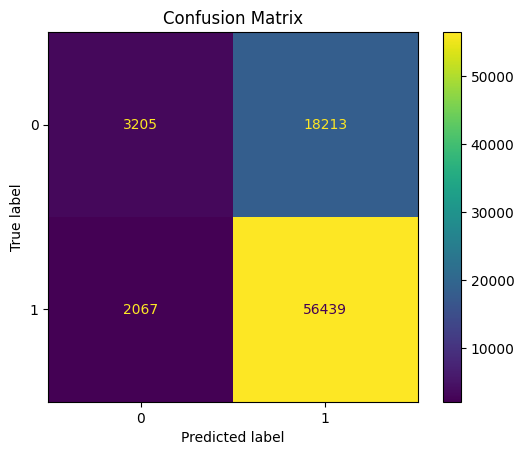

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a ConfusionMatrixDisplay object
# Pass the model's classes if available, otherwise use unique values from y_test
display_labels = best_model.classes_ if hasattr(best_model, 'classes_') else sorted(y_test.unique())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)

# Plot the confusion matrix
disp.plot()

# Add a title to the plot
plt.title("Confusion Matrix")

# Display the plot
plt.show()

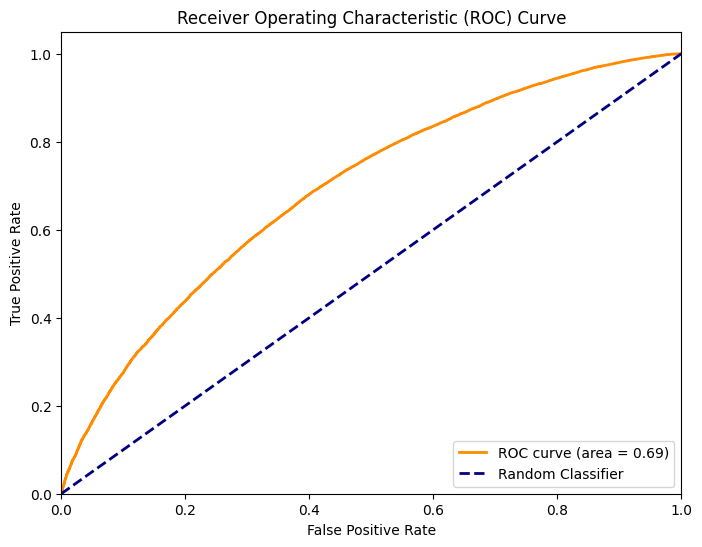

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Calculate the predicted probabilities for the positive class (class 1) on the test set
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Compute the false positive rates (fpr), true positive rates (tpr), and thresholds for the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Calculate the Area Under the ROC Curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

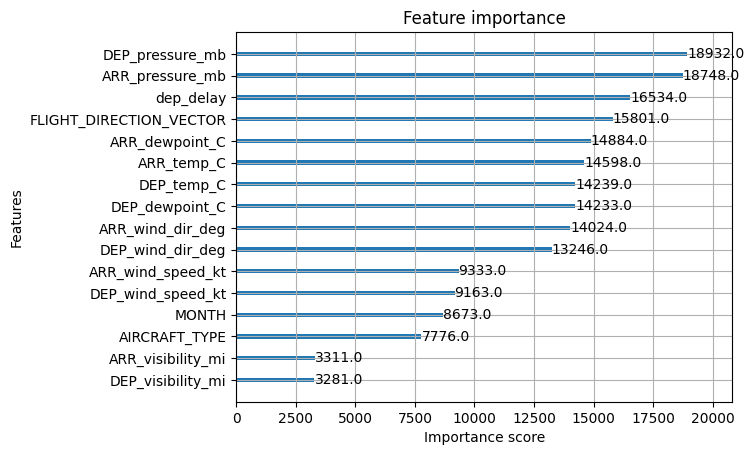

In [ ]:
import xgboost

xgboost.plot_importance(best_model)
